In [1]:
import igraph as ig
from haversine import haversine, Unit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas

dataset_path = "../dataset"

## Helper Classes

In [11]:
class DatasetGraphGenerator:

    def __init__(self, naptan_dataset_path, graph_params) -> None:
        self.dataset_path = naptan_dataset_path
        self.graph_params = graph_params
        self.igraph = None
        self.df = None
        self.generate_graph()

    def generate_graph(self) -> ig.Graph:
        df = pd.read_csv(self.dataset_path)
        filtered_df = df[df['LocalityName'] == "Westminster"]
        filtered_df = df[["NaptanCode", "CommonName", "LocalityName", "Longitude", "Latitude"]]
        # sampled_df = filtered_df.sample(n=self.params['num_locations'])#
        sampled_df = filtered_df
        self.df = sampled_df
        
        igraph = ig.Graph.Full(n=sampled_df.size, loops=False)
        igraph.vs['location_id'] = list(sampled_df["NaptanCode"])
        igraph.vs["coordinate"] = list(zip(sampled_df["Latitude"], sampled_df["Longitude"]))
        igraph.vs["common_name"] = list(sampled_df["CommonName"])
        for edge in igraph.es:
            source_vertex = igraph.vs[edge.source]
            target_vertex = igraph.vs[edge.target]
            
            source_coordinates = source_vertex["coordinate"]
            target_coordinate = target_vertex["coordinate"]
            distance = haversine(source_coordinates, target_coordinate, unit=Unit.METERS)

            travel_time = distance / 19.76
            edge["distance"] = distance
            edge["travel_time"] = travel_time
        
        self.igraph = igraph

## Helper Functions

In [68]:
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

def plot(df):
    fp = "../dataset/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
    map_df = geopandas.read_file(fp)
    multi_poly = MultiPolygon(list(map_df['geometry']))
    map_df['geometry'] = geopandas.GeoSeries(multi_poly)
    
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe

    gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
    map_df.plot(ax=gdf.plot())
    plt.show()



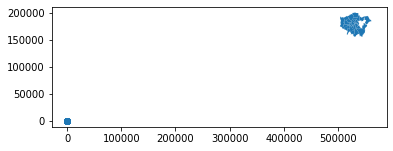

In [69]:
graph_generator = DatasetGraphGenerator(f"{dataset_path}/westminster_hackney_stops.csv", None)
plot(graph_generator.df)
